## SPAM/HAM CLASSIFIER USING NAIVE BAYES

#### Steps to be followed:
1. Preprocess the data.
    1. Remove repeated entries if exists
    2. Remove punctuation
    3. Remove not relevant special characters 
    4. Obtain a list of clean text words 	
2. Split train and test dataset 
3. Create the model (convert strings to integer counts, obtain frequency of the words and create the model using Naïve Bayes formula).
4. Test the model. 
5. Create a confusion matrix on your prediction for test dataset. 
6. Make analysis report for your model and results. 

####  DATA PREPROCESSING

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#import the dataset with proper encoding :
dataset = pd.read_csv('spam_ham_data_set.csv', encoding='latin-1')
dataset = dataset[["v1","v2"]]
dataset = dataset.rename(columns={"v1":"label", "v2":"text"})
dataset.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label    5572 non-null object
text     5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB
None
ham     4825
spam     747
Name: label, dtype: int64


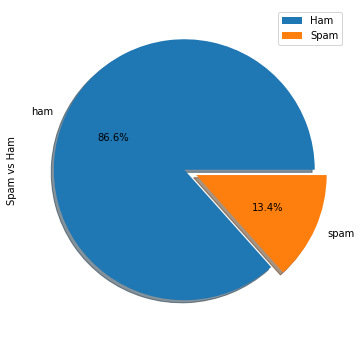

In [3]:
print(dataset.info())
print(dataset.label.value_counts())

dataset["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

In [4]:
#picking up a few top messages and erasing all the duplicates in them
top = dataset.groupby("text")["label"].agg([len, np.max]).sort_values(by = "len", ascending = False).head(n = 10)
print(top)
dataset.drop_duplicates(keep=False, inplace=True)
print(dataset.shape)

                                                    len  amax
text                                                         
Sorry, I'll call later                               30   ham
I cant pick the phone right now. Pls send a mes...   12   ham
Ok...                                                10   ham
Your opinion about me? 1. Over 2. Jada 3. Kusru...    4   ham
Wen ur lovable bcums angry wid u, dnt take it s...    4   ham
Please call our customer service representative...    4  spam
Okie                                                  4   ham
Say this slowly.? GOD,I LOVE YOU &amp; I NEED Y...    4   ham
7 wonders in My WORLD 7th You 6th Ur style 5th ...    4   ham
Ok.                                                   4   ham
(4888, 2)


In [5]:
#nltk : Natural language toolkit : tokenize and clean the data
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")    #for crude estimation to root words

Imported the text preprocessing libraries and cleaning up the dataset by removing all punctuation marks

In [6]:
def cleanText(msg):
    msg = msg.translate(str.maketrans('', '', string.punctuation))
    words = [stemmer.stem(word) for word in msg.split() if word.lower() not in stopwords.words("english")]
    return " ".join(words)

In [7]:
dataset["text"] = dataset["text"].apply(cleanText)
dataset = dataset[["label","text"]]
dataset.head()

,label,text
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif u oni
3,ham,u dun say earli hor u c alreadi say
4,ham,nah dont think goe usf live around though
5,spam,freemsg hey darl 3 week word back id like fun ...


In [8]:
#Creating the dependent and independent variables
X = dataset.iloc[:,1].values
y = dataset.iloc[:,0].values

In [9]:
#Splitting into training set and test set
from sklearn.model_selection import train_test_split
text_train, text_test, label_train, label_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [10]:
display(len(text_train))
display(len(text_test))
display(len(label_train))
display(len(label_test))

3910

978

3910

978

#### CREATING DICTIONARIES

In [11]:
#Dictionary of all words
messages = dataset.text.values
words_all = []
for message in messages:
    words_all += (message.split(" "))
unique_words = set(words_all)
dictionary_words = {i:words_all.count(i) for i in unique_words}
dictionary_words['hello']

41

In [12]:
#Dictionary of all spam words
spam_messages = dataset.text.values[dataset.label == "spam"]
spam_words = []
for spam in spam_messages:
    spam_words += (spam.split(" "))
unique_spam_words = set(spam_words)
dictionary_spam = {i:spam_words.count(i) for i in unique_spam_words}
dictionary_spam['win']

35

In [13]:
#Dictionary of all ham words
ham_messages = dataset.text.values[dataset.label == "ham"]
ham_words = []
for ham in ham_messages:
    ham_words += (ham.split(" "))
unique_ham_words = set(ham_words)
dictionary_ham = {i:ham_words.count(i) for i in unique_ham_words}
dictionary_ham['love']

194

In [14]:
total_words = len(words_all)
total_spam = len(spam_words)
total_ham = len(ham_words)
print(total_words, total_spam, total_ham)

44161 9226 34935


#### FINDING PROBABILITIES AND LAPLACE SMOOTHING

Now we perform the following steps:

1. Find Different Probabilities:
    1. Prior probabilities
    2. Likelihood
    3. Marginal Likelihood
2. Do laplace smoothing to avoid the zero denominator case
3. Apply the Naive bayes theorem

In [15]:
def prob_spam(word):
    return (dictionary_spam[word]/total_spam) 

def prob_ham(word):
    return dictionary_ham[word]/total_ham 

def prob_word(word):
    try:
        return dictionary_words[word]/total_words
    except KeyError:
        return 0.000000001 

def prob_msg_spam(message):
    num = den = 1
    for word in message.split():
        if word in spam_words:
            num *= prob_spam(word)
            den *= prob_word(word)
    
    # Laplace Smoothing step 
    if den==0:
        num+=1
        den+=1
    return num/den

def prob_msg_ham(message): 
    num = den = 1
    for word in message.split():
        if word in ham_words:
            num *= prob_ham(word)
            den *= prob_word(word)
    # Laplace Smoothing step
    if den==0:
        num+=1
        den+=1
    return num/den

def spam_pred(msg):
    if prob_msg_spam(msg) >= prob_msg_ham(msg):
        return "spam"
    else:
        return "ham"

#### GENERATING CONFUSION MATRIX AND DETERMINING ACCURACY

The above probability functions are used by us to create the confusion matrix to find the accuracy

In [16]:
def accuracy(text_test, label_test):
    false_positive = false_negative = 0 
    true_positive = true_negative = 0
    for i,m in enumerate(text_test):
        predicted = spam_pred(m)
        actual = label_test[i]
        if predicted == "spam" and actual == "spam":
            true_negative+=1
        if predicted == "spam" and actual == "ham":
            false_negative+=1
        if predicted == "ham" and actual == "spam":
            false_positive+=1
        if predicted == "ham" and actual == "ham":
            true_positive+=1
    acc = (true_negative+true_positive)/len(text_test)
    return acc, false_positive, false_negative, true_positive, true_negative

In [17]:
acc,fp,fn,tp,tn = accuracy(text_test,label_test)
print("The accuracy of the classifier is: " + str(acc*100) + " %") 

The accuracy of the classifier is: 94.68302658486708 %


In [18]:
print("True positive: ",tp,"\n False positive: ",fp,"\n False Negative: ",fn,"\n True Negative: ",tn)   

True positive:  832 
 False positive:  4 
 False Negative:  48 
 True Negative:  94


Thus, we create our classifier easily, on Naiive Bayes Theorem, with an accuracy of 94.683% 